# 1. Importar libs e carregar os DataFrames

In [1]:
from bibliotecas.eda import *
from bibliotecas.limpeza import *

In [2]:
import missingno as msno
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import geopandas as gpd
import time
from datetime import datetime
from datetime import timedelta
%matplotlib inline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# preprocessing and pipeline
from sklearn.preprocessing import (StandardScaler,  # REESCALANDO FEATURES
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   LabelEncoder)
from sklearn.pipeline import Pipeline # CRIANDO PIPELINES
from sklearn import set_config

import category_encoders as ce

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, RFE  # SELEÇÃO DE FEATURES
from sklearn.ensemble import RandomForestClassifier

# mode selection and metrics
from sklearn.model_selection import (train_test_split,  # METRICAS
                                     GridSearchCV,
                                     KFold,
                                     cross_val_score)
from sklearn import metrics

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             precision_score, 
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve
                            )

# warnings option
import warnings
warnings.filterwarnings('ignore')

# 2 - Lendo Arquivos

In [3]:
df_nonan = pd.read_pickle('dados/df_nonan.pkl')
df_municipios = pd.read_csv('dados/Codigo_Nome_Municipios.txt', encoding ='ANSI', sep=';')
df_coordenadas = pd.read_csv('dados/Sedes_Coordenadas_Municipios.csv', encoding ='utf8', delimiter=";")

# 3 - Modelagem

## 3.1 - Ajuste da Coluna de data

In [4]:
# convertendo a coluna data_inicio_sintomas para datetime
df_nonan['data_inicio_sintomas'] = pd.to_datetime(df_nonan['data_inicio_sintomas'].astype('datetime64'))

In [5]:
# sorting pela data
df_nonan =df_nonan.sort_values(by='data_inicio_sintomas', ascending=True)

In [6]:
# colocando a coluna de data como index
df_nonan= df_nonan.set_index('data_inicio_sintomas')

In [7]:
menor_data = df_nonan.index.min()
maior_data = df_nonan.index.max()
print('Temos uma serie temporal com data incial em :' , menor_data, 'e data final em :',maior_data)

Temos uma serie temporal com data incial em : 2020-02-04 00:00:00 e data final em : 2021-11-05 00:00:00


In [24]:
# dataframe com data dos obitos
df_nonan_temporal = pd.DataFrame(df_nonan[['obito']])

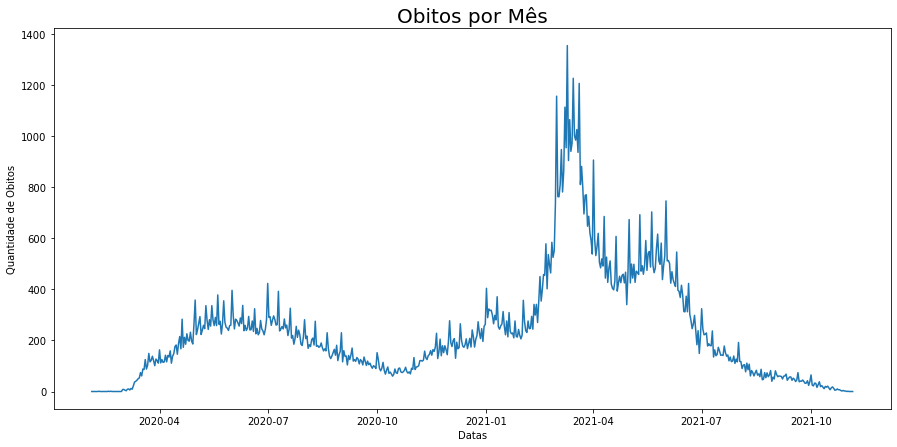

In [28]:
# ploto dos obitos ao longo dos meses
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(df_nonan_temporal.reset_index().groupby('data_inicio_sintomas').sum())
plt.title('Obitos por Mês',fontsize=20)
plt.ylabel('Quantidade de Obitos')
plt.xlabel('Datas')
plt.show()

In [29]:
# substituindo 0:'recuperado',1:'falecido'
df_nonan_temporal['obito']=df_nonan_temporal['obito'].map({0:'recuperado',1:'falecido'})

# 3.2 - Encoders

# 3.2.1 - Colunas Discretas

In [14]:
# passando o encoder
encoder = ce.BinaryEncoder(cols=['obito'])
dfbin = encoder.fit_transform(df_nonan_temporal['obito'])

In [17]:
# falecidos e recuperados por mes
dfbin_month = dfbin.reset_index().groupby('data_inicio_sintomas').sum()
dfbin_month = dfbin_month.rename(columns={'obito_0':'falecido', 'obito_1': 'recuperado'})

In [19]:
# aplicando minmax scaler para que os obitos e recuperados fiquem na mesma escala
scaler = MinMaxScaler()
dfbin_month_scaled = scaler.fit_transform(dfbin_month)

No handles with labels found to put in legend.


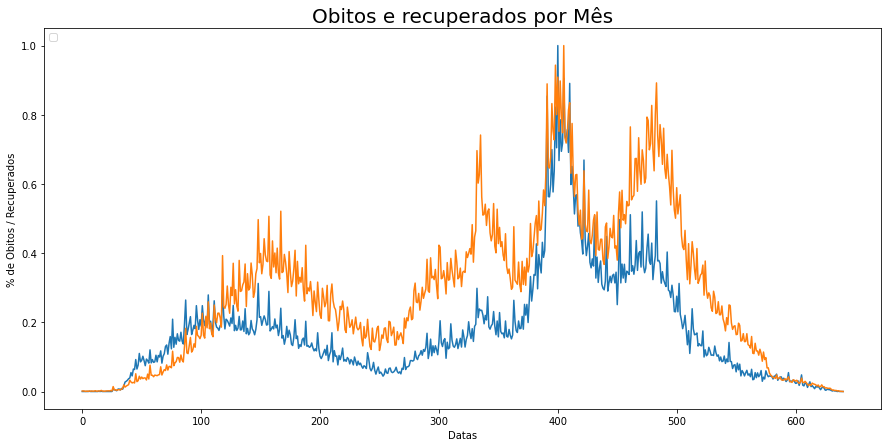

In [20]:
# plot de obitos e recuperados por mes (mesma escala)
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(dfbin_month_scaled)
plt.title('Obitos e recuperados por Mês',fontsize=20)
plt.ylabel('% de Obitos / Recuperados')
plt.xlabel('Datas')
plt.legend(loc="upper left")
plt.show()

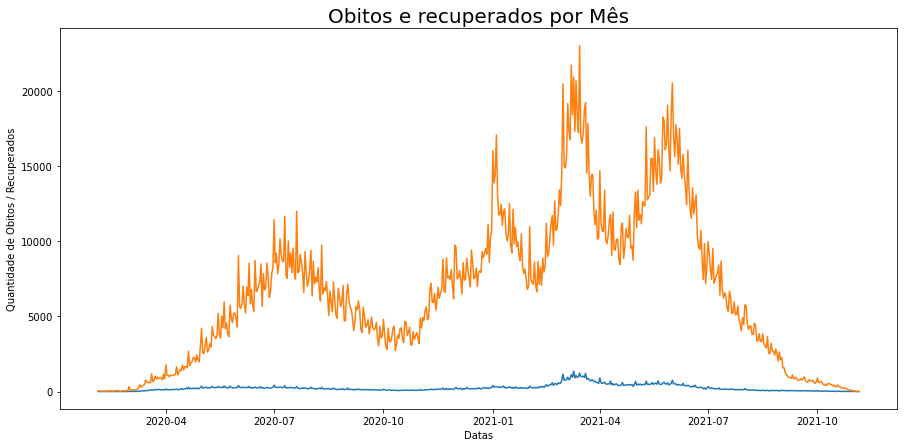

In [36]:
# plot de obitos e recuperados por mes (escalas diferentes)
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(dfbin_month)
plt.title('Obitos e recuperados por Mês',fontsize=20)
plt.ylabel('Quantidade de Obitos / Recuperados')
plt.xlabel('Datas')
plt.show()

## 3.2.2 - Colunas Categoricas

In [30]:
# criando dummies para a coluna cs_sexo e diagnostico_covid19
df_nonan = pd.get_dummies(df_nonan, prefix = ['sexo'], columns =['cs_sexo'])
df_nonan = pd.get_dummies(df_nonan, prefix = ['diagnostico'], columns =['diagnostico_covid19'])

Usando Replace e classificando os niveis
- IGNORADO = peso fraco - 1 
- NÃO      = peso médio - 2
- SIM      = peso forte - 3

In [32]:
# aplicando replace e resetando o index
resposta = {'IGNORADO':1,'NÃO':2,'SIM':3}
df_nonan_reposta = df_nonan.replace(resposta) 
df_nonan_reposta = df_nonan_reposta.reset_index()

In [33]:
df_nonan_reposta.head(4)

,data_inicio_sintomas,nome_munic,codigo_ibge,idade,obito,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,...,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,sexo_FEMININO,sexo_MASCULINO,diagnostico_CONFIRMADO
0,2020-02-04,Itatiba,3523404,26.0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
1,2020-02-04,Barueri,3505708,40.0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
2,2020-02-04,Araraquara,3503208,24.0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
3,2020-02-04,Morungaba,3532009,21.0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


# 4 - Criando dataframe de Target e Variaveis Explicativas 

In [42]:
df_nonan_reposta.columns

Index(['data_inicio_sintomas', 'nome_munic', 'codigo_ibge', 'idade', 'obito',
       'asma', 'cardiopatia', 'diabetes', 'doenca_hematologica',
       'doenca_hepatica', 'doenca_neurologica', 'doenca_renal',
       'imunodepressao', 'obesidade', 'outros_fatores_de_risco', 'pneumopatia',
       'puerpera', 'sindrome_de_down', 'sexo_FEMININO', 'sexo_MASCULINO',
       'diagnostico_CONFIRMADO'],
      dtype='object')

In [34]:
# variaveis nao explicativas
colunms_drop = ['data_inicio_sintomas','nome_munic','codigo_ibge','obito','diagnostico_CONFIRMADO']

In [35]:
# variaveis explicativas
X = df_nonan_reposta.drop(columns=colunms_drop)
# variável target
y = df_nonan_reposta['obito']

In [38]:
# dataframde com as variaveis explicativas
X.head()

,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,sexo_FEMININO,sexo_MASCULINO
0,26.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
1,40.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
2,24.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
3,21.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4,29.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [39]:
# dataframe com a variavel target
y.head()

0    0
1    0
2    0
3    0
4    0
Name: obito, dtype: int64

# 5 - Dividindo Treino e Teste

In [40]:
seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = seed)

# 6 - Aplicando o modelo

In [43]:
model_logistic = LogisticRegression()

## 6.1 - Seleção de Features

In [44]:
#Aplicando o RFE
#quero que selecione as 5 features mais importantes
rfe = RFE(model_logistic, n_features_to_select = 5, step = 1) 
# modelo utilizado de regressão logistica /  n_features_to_select =quantidade de features a permanecer / step = de quanto em quantas colunas eu removo 
fit = rfe.fit(X, y)

In [59]:
# visualizando os índices:
cols = fit.get_support(indices=True)
cols

array([ 6, 10, 11, 14, 15], dtype=int64)

In [62]:
# ABAIXO O DATASET COM SOMENTE AS COLUNAS QUE O RFE SELECIONOU COMO MAIS IMPORTANTES PARA O MODELO
df_nonan.iloc[:,cols]

,diabetes,doenca_renal,imunodepressao,pneumopatia,puerpera
data_inicio_sintomas,,,,,
2020-02-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2020-02-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2020-02-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2020-02-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2020-02-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
...,...,...,...,...,...
2021-11-04,SIM,NÃO,NÃO,NÃO,NÃO
2021-11-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2021-11-04,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
